# Exercise: Transfer learning using MobileNetV3

In the field of machine learning, transfer learning is a powerful technique that leverages pre-trained models and applies them to new tasks. This approach allows us to save time and computational resources by reusing the knowledge gained from training on large datasets.

In this exercise we use MobileNetV3, a convolutional neural network architecture for mobile devices, to train a classifier for the Fashion-MNIST dataset using the PyTorch framework.

Fashion-MNIST is a drop-in replacement for MNIST (images of size 28x28 with 10 classes) but instead of hand-written digits it contains tiny images of clothes!

## Steps

1. Load the Fashion-MNIST dataset using the torchvision package.
2. Define a PyTorch model using the MobileNetV3 architecture.
3. Train the model on the Fashion-MNIST dataset.
4. Evaluate the model on the test set.

## Environment Setup (Apple Silicon Macs)

Run this once in the notebook before training. It installs the core packages and works on M1/M2/M3 Macs.

After installation, restart the kernel and run all cells from the top.

If you still see the `InvalidVersion` error, run this once in a terminal and restart Jupyter:

```bash
python -m pip uninstall -y pyodbc
```


In [ ]:
# Apple Silicon friendly installs (skip pip self-upgrade to avoid pyodbc metadata issues)
%pip install -U setuptools wheel
%pip install -U "torch>=2.2" "torchvision>=0.17" "torchaudio>=2.2"
%pip install -U matplotlib numpy


In [3]:
python -m pip uninstall -y pyodbc
python -m pip install -U setuptools wheel
python -m pip install -U "torch>=2.2" "torchvision>=0.17" "torchaudio>=2.2" matplotlib numpy

SyntaxError: invalid syntax (<ipython-input-3-09532e876ec9>, line 1)

## Step 1: Load the Fashion-MNIST dataset

The torchvision package provides access to popular datasets, model architectures, and image transformations for computer vision.


### Dataset Source Notes

- Primary loader in this notebook: `torchvision.datasets.FashionMNIST` (auto-download).
- Kaggle mirror: [Fashion MNIST on Kaggle](https://www.kaggle.com/datasets/zalando-research/fashionmnist/data).

### Why `Normalize((0.5,), (0.5,))`?

After `ToTensor()`, each pixel is in `[0, 1]`. Normalization applies:

$x_{norm} = \frac{x - 0.5}{0.5} = 2x - 1$

So values become `[-1, 1]` (centered around 0), which usually improves optimization stability and speed.

If you skip normalization, training can still work, but convergence is often slower/less stable and learning-rate tuning becomes more sensitive.


In [14]:
# Load the Fashion-MNIST dataset

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms


def load_data(batch_size, data_dir="data"):
    """Load the Fashion-MNIST dataset."""

    # Define transforms to normalize the data
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )

    # Download and load the training data
    trainset = datasets.FashionMNIST(
        data_dir, download=True, train=True, transform=transform
    )
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True
    )

    # Download and load the test data
    testset = datasets.FashionMNIST(
        data_dir, download=True, train=False, transform=transform
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=True
    )

    return trainloader, testloader


trainloader, testloader = load_data(64)

Sometimes it's useful to create functions that will help us work with the labels when they're a little more complicated than the handwritten digits 0-9. Let's create those now.

In [15]:
# Define some helper functions to helps with the labels
def get_class_names():
    """Return the list of classes in the Fashion-MNIST dataset."""
    return [
        "T-shirt/top",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat",
        "Sandal",
        "Shirt",
        "Sneaker",
        "Bag",
        "Ankle boot",
    ]


def get_class_name(class_index):
    """Return the class name for the given index."""
    return get_class_names()[class_index]


def get_class_index(class_name):
    """Return the class index for the given name."""
    return get_class_names().index(class_name)


for class_index in range(10):
    print(f"class_index={class_index}, class_name={get_class_name(class_index)}")

class_index=0, class_name=T-shirt/top
class_index=1, class_name=Trouser
class_index=2, class_name=Pullover
class_index=3, class_name=Dress
class_index=4, class_name=Coat
class_index=5, class_name=Sandal
class_index=6, class_name=Shirt
class_index=7, class_name=Sneaker
class_index=8, class_name=Bag
class_index=9, class_name=Ankle boot


It's always good to inspect your data before you use it to train a model just to know everything is fine. You know what they say: garbage in, garbage out.

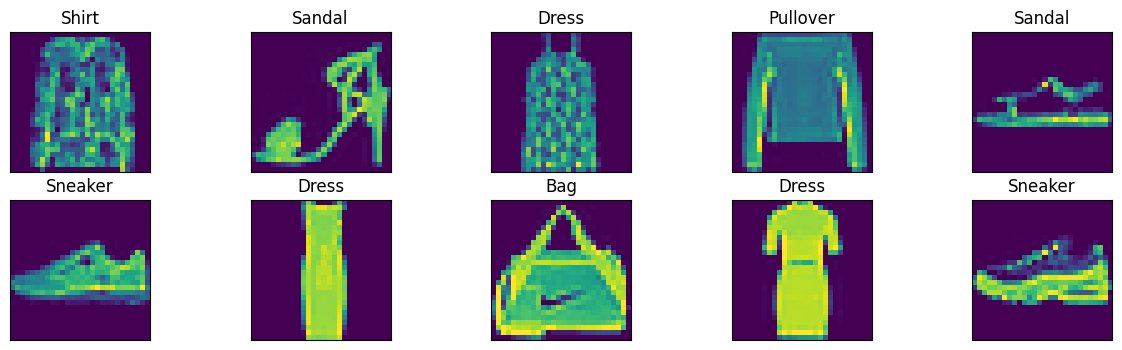

In [16]:
# Show 10 images from the training set with their labels

import matplotlib.pyplot as plt
import numpy as np


# function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()  # convert from tensor to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # transpose dimensions


images, labels = next(iter(trainloader))  # get the first batch

# show images with labels
fig = plt.figure(figsize=(15, 4))
plot_size = 10

for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size // 2, idx + 1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(get_class_name(int(labels[idx])))

## Step 2. Define a PyTorch model using the MobileNetV3 architecture.

The `torchvision.models.mobilenet_v3_large` class provides access to pre-trained MobileNetV3 model. We can use the model and replace the final layer with a fully-connected layer with 10 outputs since we have 10 classes. We can then freeze the weights of the convolutional layers and train only the new fully-connected layer.

Let's start with inspecting the original MobileNetV3 (small version) first:

## Math Deep Dive: What MobileNetV3 Is Computing

### 1) Convolution Output Shape

For input height/width $H, W$, kernel $K$, padding $P$, stride $S$:

$$H_{out} = \left\lfloor\frac{H + 2P - K}{S}\right\rfloor + 1, \quad W_{out} = \left\lfloor\frac{W + 2P - K}{S}\right\rfloor + 1$$

This is why we resize to `224x224`: the pretrained network expects an ImageNet-like spatial scale.

### 2) Standard vs Depthwise-Separable Convolution

If input channels are $M$, output channels are $N$, kernel is $K \times K$:

- Standard conv parameters: $K^2MN$
- Standard conv MACs (roughly): $H_{out}W_{out}K^2MN$
- Depthwise + pointwise parameters: $K^2M + MN$
- Depthwise + pointwise MACs (roughly): $H_{out}W_{out}(K^2M + MN)$

This reduction is the core efficiency trick in MobileNet families.

### 3) Squeeze-and-Excitation (SE) Channel Attention

Given feature map $U \in \mathbb{R}^{C \times H \times W}$:

1. **Squeeze** (global average pool):
$$z_c = \frac{1}{HW}\sum_{i=1}^{H}\sum_{j=1}^{W}U_{c,i,j}$$
2. **Excitation** (small MLP + sigmoid):
$$s = \sigma(W_2 \, \delta(W_1 z))$$
3. **Reweight channels**:
$$\tilde{U}_{c,i,j} = s_c \cdot U_{c,i,j}$$

SE learns which channels matter more for the current input.

### 4) Classification Head, Softmax, and Cross-Entropy

Final linear layer gives logits $\mathbf{z} \in \mathbb{R}^{10}$.

$$p_k = \mathrm{softmax}(\mathbf{z})_k = \frac{e^{z_k}}{\sum_j e^{z_j}}$$

For true class $y$, cross-entropy is:

$$\mathcal{L} = -\log p_y$$

Gradient wrt logits (key training identity):

$$\frac{\partial \mathcal{L}}{\partial z_k} = p_k - \mathbb{1}[k=y]$$

This is the error signal that backpropagates into earlier layers.

### 5) Why Freezing Works in Transfer Learning

When a parameter is frozen (`requires_grad=False`), its update is effectively:

$$\theta_{t+1} = \theta_t$$

Only unfrozen parameters (here, the final classifier layer) get gradient updates:

$$\theta_{t+1} = \theta_t - \eta \nabla_{\theta} \mathcal{L}$$


In [17]:
# Numeric example: convolution shape + parameter/MAC comparison
import math

H, W = 224, 224
K, P, S = 3, 1, 2
M, N = 32, 64

H_out = math.floor((H + 2 * P - K) / S) + 1
W_out = math.floor((W + 2 * P - K) / S) + 1

params_std = (K**2) * M * N
params_dw = (K**2) * M + M * N

macs_std = H_out * W_out * params_std
macs_dw = H_out * W_out * params_dw

print(f"Output shape: ({H_out}, {W_out})")
print(f"Standard conv params: {params_std:,}")
print(f"Depthwise-separable params: {params_dw:,}")
print(f"Parameter reduction: {params_std / params_dw:.2f}x")
print(f"Standard conv MACs (approx): {macs_std:,}")
print(f"Depthwise-separable MACs (approx): {macs_dw:,}")
print(f"MAC reduction: {macs_std / macs_dw:.2f}x")


Output shape: (112, 112)
Standard conv params: 18,432
Depthwise-separable params: 2,336
Parameter reduction: 7.89x
Standard conv MACs (approx): 231,211,008
Depthwise-separable MACs (approx): 29,302,784
MAC reduction: 7.89x


In [18]:
# Numeric example: softmax, cross-entropy, and gradient wrt logits
import torch
import torch.nn.functional as F

# One sample, 3 classes (toy example)
logits = torch.tensor([[2.0, 0.5, -1.0]], requires_grad=True)
target = torch.tensor([0])  # true class index

probs = torch.softmax(logits, dim=1)
loss = F.cross_entropy(logits, target)
loss.backward()

print(f"Logits: {logits.detach().numpy()}")
print(f"Softmax probabilities: {probs.detach().numpy()}")
print(f"Cross-entropy loss: {loss.item():.6f}")
print(f"Gradient dL/dlogits: {logits.grad.numpy()}")

# Compare against analytic form p - one_hot(y)
one_hot = torch.zeros_like(probs)
one_hot[0, target.item()] = 1.0
analytic_grad = probs - one_hot
print(f"Analytic p - one_hot: {analytic_grad.detach().numpy()}")


Logits: [[ 2.   0.5 -1. ]]
Softmax probabilities: [[0.785597   0.17529039 0.03911257]]
Cross-entropy loss: 0.241311
Gradient dL/dlogits: [[-0.21440297  0.17529039  0.03911257]]
Analytic p - one_hot: [[-0.21440297  0.17529039  0.03911257]]


### MobileNetV3 Intuition

MobileNetV3 is efficient because it uses **depthwise-separable convolutions** instead of full convolutions in most blocks.

For an input with $M$ channels, output with $N$ channels, and kernel size $K \times K$:

- Standard conv parameters: $K^2MN$
- Depthwise + pointwise parameters: $K^2M + MN$

Example with $K=3$, $M=32$, $N=64$:

- Standard: $3^2 \cdot 32 \cdot 64 = 18,432$
- Depthwise-separable: $3^2 \cdot 32 + 32 \cdot 64 = 2,336$

That is about **7.9x fewer parameters** for this layer shape.

MobileNetV3 also uses squeeze-and-excitation (channel attention), residual connections, and the $h\text{-}swish$ activation:

$h\text{-}swish(x) = x \cdot \frac{\mathrm{ReLU6}(x+3)}{6}$


### MobileNetV3 Block Flow (Conceptual)

`Input (1x28x28)` -> `Repeat to 3 channels` -> `Resize to 224x224` -> `MobileNetV3 feature extractor` -> `Classifier head` -> `10 Fashion-MNIST logits`

Inside MobileNetV3 feature extractor, a typical block is:

`1x1 expansion conv` -> `depthwise conv` -> `SE attention` -> `1x1 projection conv` (+ residual when shape matches).


### Detailed Flow Explanation

1. **Input `(1x28x28)`**: Fashion-MNIST is grayscale (`1` channel), resolution `28x28`.
2. **Repeat to 3 channels**: pre-trained MobileNetV3 expects RGB input (`3` channels). We copy the same grayscale plane into R/G/B, giving shape `(3x28x28)`.
3. **Resize to `224x224`**: ImageNet pretraining used `224x224` inputs. Resizing matches the scale expected by the early convolutional filters.
4. **MobileNetV3 feature extractor**: stacked efficient conv blocks convert pixels into high-level features.
5. **Classifier head**: final linear layer maps learned features to class scores.
6. **10 logits**: one raw score per Fashion-MNIST class; `argmax(logits)` gives predicted class.

Inside a typical MobileNetV3 block:

- **1x1 expansion conv**: increases channels so the block has richer intermediate representation.
- **Depthwise conv**: spatial filtering done per channel (cheap in compute/parameters).
- **SE attention**: learns channel-wise importance weights and rescales channels adaptively.
- **1x1 projection conv**: compresses channels back down to target width.
- **Residual add** (when shapes match): adds input to output to improve gradient flow and training stability.


Standard conv params: 18432
Depthwise-separable params: 2336
Reduction factor: 7.89x


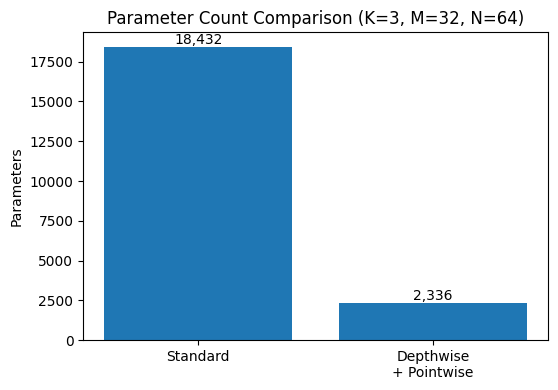

In [19]:
# Quick numeric and visual comparison: standard vs depthwise-separable conv
import matplotlib.pyplot as plt

K, M, N = 3, 32, 64
standard_params = (K**2) * M * N
depthwise_separable_params = (K**2) * M + M * N
reduction = standard_params / depthwise_separable_params

print(f"Standard conv params: {standard_params}")
print(f"Depthwise-separable params: {depthwise_separable_params}")
print(f"Reduction factor: {reduction:.2f}x")

labels = ["Standard", "Depthwise\n+ Pointwise"]
values = [standard_params, depthwise_separable_params]

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, values)
plt.title("Parameter Count Comparison (K=3, M=32, N=64)")
plt.ylabel("Parameters")
for b, v in zip(bars, values):
    plt.text(b.get_x() + b.get_width() / 2, v, f"{v:,}", ha="center", va="bottom")
plt.show()


In [20]:
# Load a pre-trained MobileNetV3 and inspect its structure
import torchvision.models as models

mobilenet_v3_model = models.mobilenet_v3_small(
    weights=models.MobileNet_V3_Small_Weights.DEFAULT
)
print(mobilenet_v3_model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

Take note of the `classifier` section of the model.

```
  (classifier): Sequential(
    (0): Linear(in_features=576, out_features=1024, bias=True)
    (1): Hardswish()
    (2): Dropout(p=0.2, inplace=True)
    (3): Linear(in_features=1024, out_features=1000, bias=True)
  )
```

There are 1000 output features, but our dataset does not have that many. See if you can complete the next cell so that it has the right number of output nodes.

In [21]:
import torch.nn.functional as F
import torchvision.models as models
from torch import nn


# Define a model class that extends the nn.Module class
class MobileNetV3(nn.Module):
    def __init__(self):
        super(MobileNetV3, self).__init__()

        # Load the pre-trained MobileNetV3 (Small) architecture
        self.model = models.mobilenet_v3_small(
            weights=models.MobileNet_V3_Small_Weights.DEFAULT
        )

        # Replace the last fully-connected layer with a new one of the right size
        self.model.classifier[3] = nn.Linear(in_features=1024, out_features=10)

        # Freeze all the weights of the network except for the last fully-connected layer
        self.freeze()

    def forward(self, x):
        # Convert 1x28x28 input tensor to 3x28x28 tensor, to convert it to a color image
        x = x.repeat(1, 3, 1, 1)

        # Resize the input to 224x224, since MobileNetV3 (Small) expects images of that size
        if x.shape[2:] != (224, 224):
            x = F.interpolate(x, size=(224, 224), mode="bilinear", align_corners=False)

        # Forward pass
        return self.model(x)

    def freeze(self):
        # Freeze all the weights of the network except for the last fully-connected layer
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze the final layer
        for param in self.model.classifier[3].parameters():
            param.requires_grad = True

    def unfreeze(self):
        # Unfreeze all the weights of the network
        for param in self.model.parameters():
            param.requires_grad = True


# Create an instance of the MobileNetV3 model
model = MobileNetV3()
print(model)


MobileNetV3(
  (model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Conv2d

## Step 3. Train the model on the MNIST dataset

We can train the model using the standard PyTorch training loop. For the loss function, we'll use CrossEntropyLoss. We also use the Adam optimizer with a learning rate of 0.002. We train the model for 1 epoch so we can see how the model performs after just one pass of the training data.

In [22]:
import torch
import torch.nn as nn

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)


Now let's choose our device automatically (CPU, GPU, or MPS) and write our training loop!

The MPS backend is for M1/M2/etc Macs.

If you are having any errors running the code locally, you should try to use the `cpu` mode manually, i.e. `device = torch.device("cpu")`

In [23]:
# Set the device as GPU, MPS, or CPU according to availability
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [24]:
# Create a PyTorch training loop

model = model.to(device)  # Move the model weights to the device
model.train()

epochs = 1
for epoch in range(epochs):
    for batch_num, (images, labels) in enumerate(trainloader):
        # Move tensors to the device
        images = images.to(device)
        labels = labels.to(device)

        # Zero out the optimizer's gradient buffer
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calculate the loss and perform backprop
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Update the weights
        optimizer.step()

        # Print the loss for every 100th iteration
        if (batch_num) % 100 == 0:
            print(
                "Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}".format(
                    epoch + 1, epochs, batch_num + 1, len(trainloader), loss.item()
                )
            )


Epoch [1/1], Batch [1/938], Loss: 2.2741
Epoch [1/1], Batch [101/938], Loss: 0.5062
Epoch [1/1], Batch [201/938], Loss: 0.5717
Epoch [1/1], Batch [301/938], Loss: 0.4647
Epoch [1/1], Batch [401/938], Loss: 0.4837
Epoch [1/1], Batch [501/938], Loss: 0.3836
Epoch [1/1], Batch [601/938], Loss: 0.4405
Epoch [1/1], Batch [701/938], Loss: 0.2850
Epoch [1/1], Batch [801/938], Loss: 0.3166
Epoch [1/1], Batch [901/938], Loss: 0.4429


## Step 4. Evaluate the model on the test set

We evaluate the model on the test set by:
* printing the accuracy
* plotting a few examples of correct and incorrect predictions.


In [25]:
# Print the loss and accuracy on the test set
correct = 0
total = 0
loss = 0.0

model.eval()
with torch.no_grad():
    for images, labels in testloader:
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss += loss_fn(outputs, labels).item()

        # torch.max return both max and argmax. We get the argmax here.
        _, predicted = torch.max(outputs.data, 1)

        # Compute the accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(
    "Test Accuracy of the model on the test images: {} %".format(100 * correct / total)
)
print("Test Loss of the model on the test images: {}".format(loss))


Test Accuracy of the model on the test images: 86.13 %
Test Loss of the model on the test images: 59.92099943757057


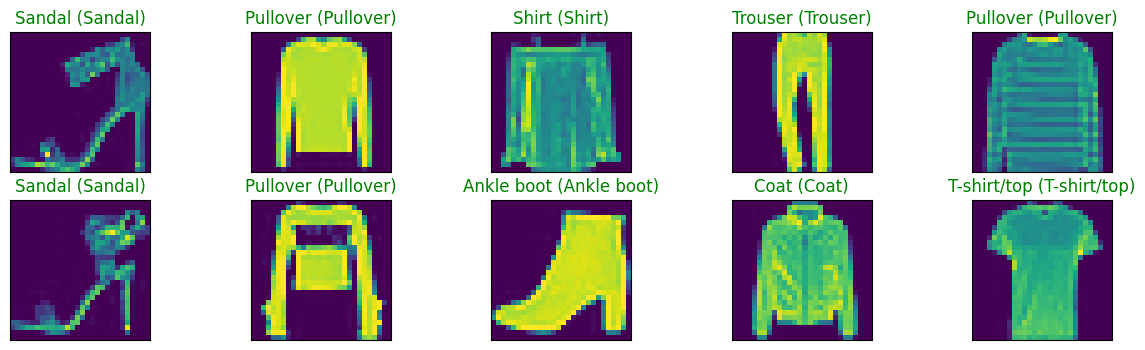

In [26]:
# Plotting a few examples of correct and incorrect predictions

import matplotlib.pyplot as plt
import numpy as np

# Get the first batch of images and labels
images, labels = next(iter(testloader))

# Move tensors to the configured device
images = images.to(device)
labels = labels.to(device)

# Forward pass
outputs = model(images)
_, predicted = torch.max(outputs.data, 1)

# Plot the images with labels, at most 10
fig = plt.figure(figsize=(15, 4))

for idx in np.arange(min(10, len(images))):
    ax = fig.add_subplot(2, 10 // 2, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images.cpu()[idx]))
    ax.set_title(
        "{} ({})".format(get_class_name(predicted[idx]), get_class_name(labels[idx])),
        color=("green" if predicted[idx] == labels[idx] else "red"),
    )